# 放“码”过来，看看在Vertica中做血缘分析有多容易
```text
                刘定强 2021.05.15 
```

时常有朋友问，用Vertica如何做数据血缘关系分析？

数据血缘关系分析是数据治理的一个重要话题，不是今天才突然冒出来的。多年以来，人们用ETL整合各种数据源到数据仓库，企业级ETL工具一般都具有血缘关系分析能力，根据data pipeline的定义信息来分析数据流向和实体之间的关系，足以帮助用户深入地了解系统中真实的数据流向、模型依赖关系和演进情况，以便逐步提高治理水平。

大数据时代的今天，这事儿就变得有点复杂了。一方面，传统ETL工具性能通常难以应付海量数据的处理要求，先加载到高性能的数据仓库再处理的ELT模式被广泛采用，而调度这些处理任务的工具往往缺乏足够的信息来进行严格的数据血缘关系分析。而另一方面，Hadoop等数据湖在前些年大行其道，人们用MR/Spark、Hive和SQL引擎、ML框架等多种不同的工具来处理不同的任务，这种碎片化的架构也把数据的血缘关系也搞“糊”了。所以“轮子”又得重新发明一遍。

Vertica统一分析仓库不仅仅是MPP架构的高性能数据仓库，它还支持就地分析HDFS和S3对象存储中开放格式数据的能力，基于全方位的数据进行关系模型建模、报表和交互式分析、机器学习模型训练和预测分析。

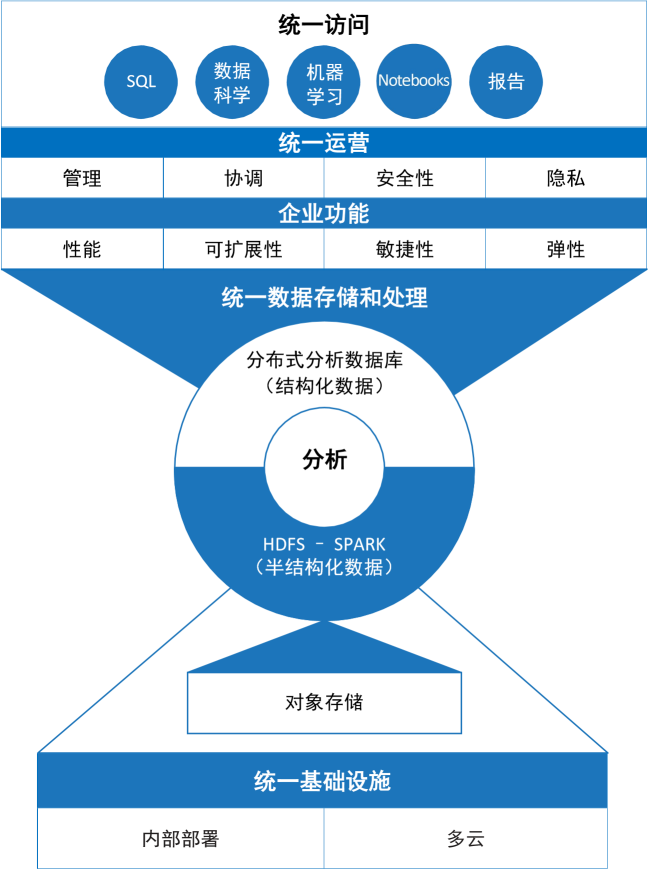

在Vertica中，所有这一切都是基于SQL来操作实现的。作为企业级的分析平台，Vertica能提供运行过程中丰富的审计和监控信息，自然也包含了“哪些用户在什么时候执行过的哪些SQL语句”、“每个SQL语句又涉及到哪些关系模型表”等信息，用它们来进行数据血缘关系分析自然是不在话下。

“Talk is cheap. Show me the code.”，好，就废话少说，咱们就放“码”过来，看看在Vertica中做数据血缘关系分析底有多容易。

## 1. 运行数据仓库模型
我们首先来运行一个模拟的影片租赁业务数据仓库模型，以便为后面的血缘分析提供样例数据。
### 1.1 准备环境

这里需要用[**VerticaPy**](https://www.vertica.com/python/)这个Python包来在Notebook中连接数据库和展示数据。VerticaPy的功能可不仅仅是连接数据库和展示数据这么简单，它基于Python语言和类scikit的接口，为数据科学家提供Vertica可扩展性能的库内机器学习功能。graphviz在后面会用来展示数据血缘关系图。

所有，我们首先检查和安装相关的包。

In [1]:
%%!
# make sure verticapy installed
grep verticapy <<< "$(python3 -m pip list)" > /dev/null \
    || python3 -m pip install -qU verticapy graphviz \
    || echo "Please manually run: python3 -m pip install -qU verticapy graphviz"

[]

然后设置访问数据库的连接属性。请注意根据您的实际情况更新相关属性值。

In [2]:
from verticapy.connect import *

# Set the primary auto-connection
new_auto_connection({"host": "localhost", 
                     "port": "5433", 
                     "database": "testdb", 
                     "user": "dbadmin",
                     "password": "youPassword"
                    },
                    name = "VerticaDSN")
change_auto_connection("VerticaDSN")

# load SqlMagic extension
%reload_ext verticapy.sql
print(verticapy.__version__)

0.6.1


,AbcVarchar(128)
1,

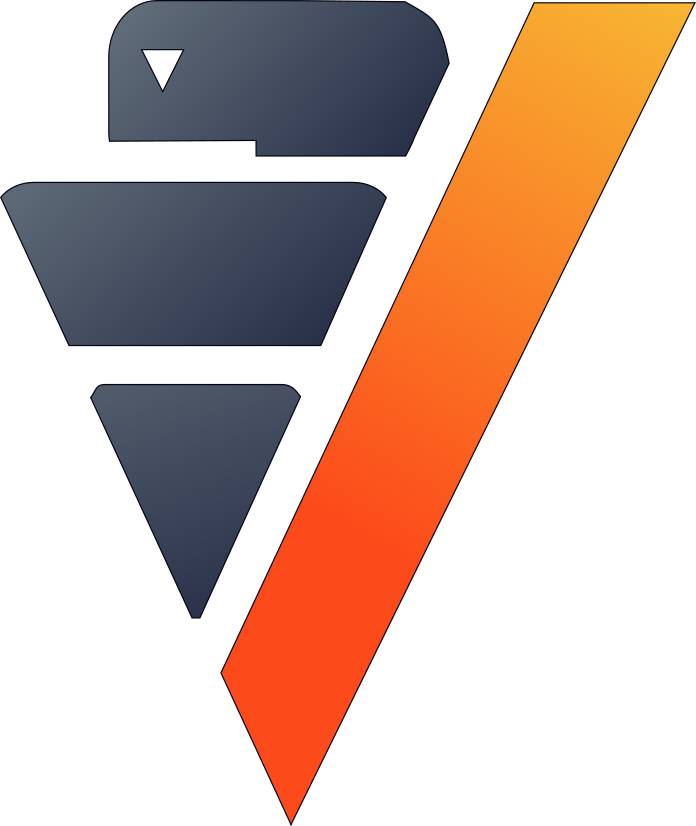

In [3]:
%sql select version();

### 1.2 创建关系模型

这里是一个“玩具”性质的星型数据仓库模型，虽然有点简单，但够用就好，因为这不是我们今天的重点。
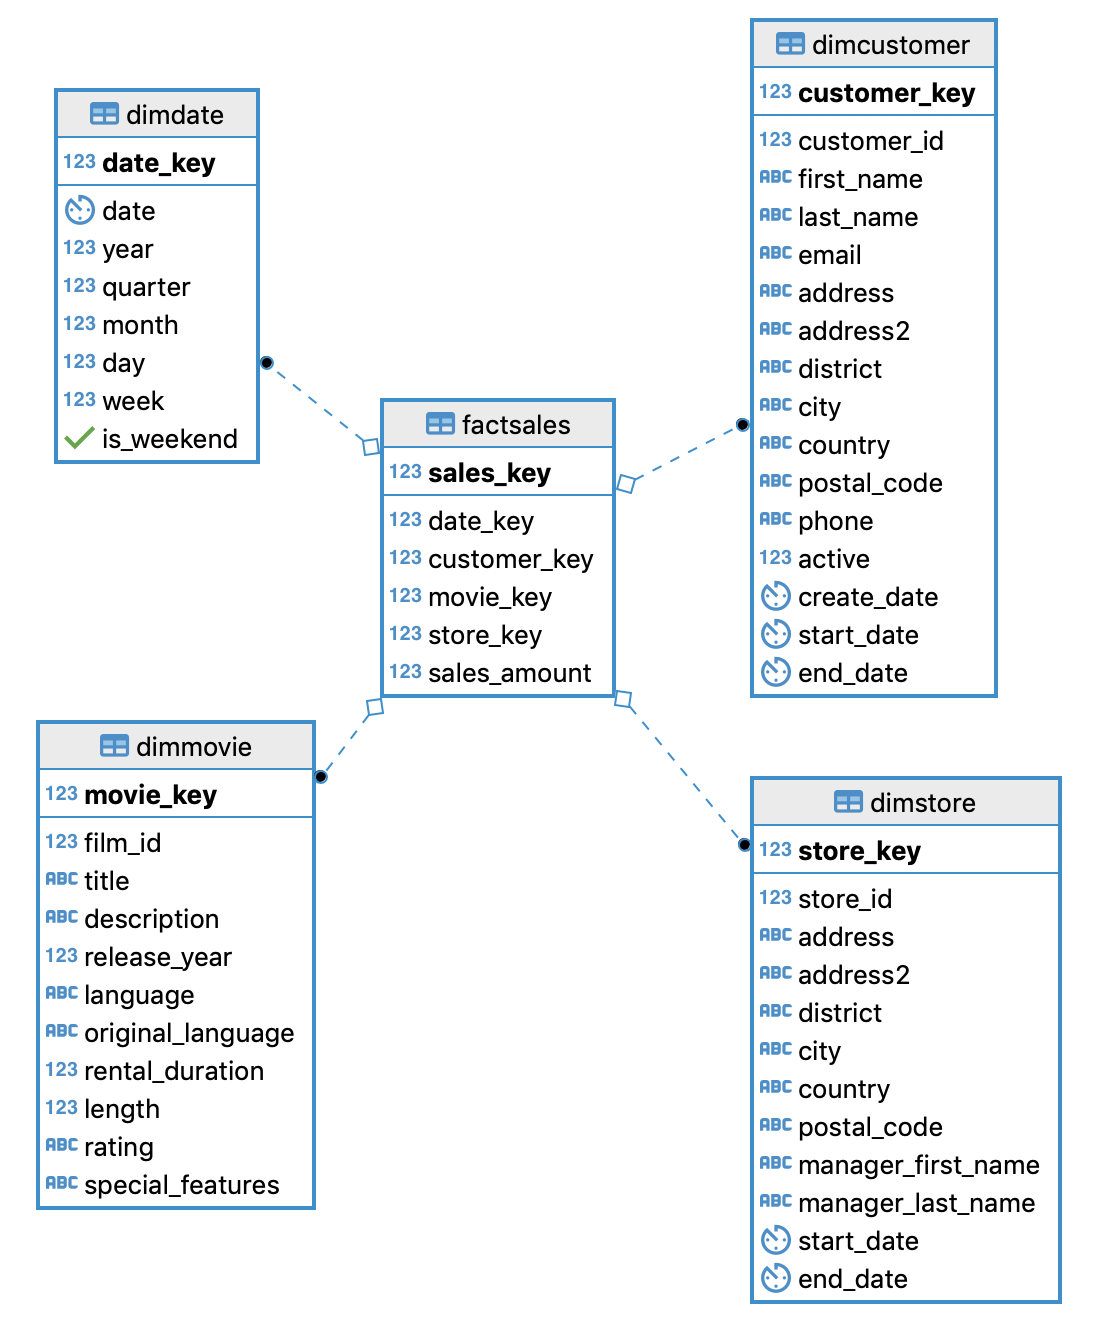


- 创建仓库模型

注意，这里给关系表都加上注释，有助于我们更好理解血缘关系数据。

In [4]:
%%sql
create schema if not exists mockdw;

CREATE TABLE if not exists mockdw.dimDate
(
    date_key integer PRIMARY KEY,
    date date NOT NULL,
    year smallint NOT NULL,
    quarter smallint NOT NULL,
    month smallint NOT NULL,
    day smallint NOT NULL,
    week smallint NOT NULL,
    is_weekend boolean NOT NULL
)
;
COMMENT ON TABLE mockdw.dimDate IS '日期(维度)';

CREATE TABLE if not exists mockdw.dimCustomer
(
  customer_key integer PRIMARY KEY,
  customer_id  smallint NOT NULL,
  first_name   varchar(45) NOT NULL,
  last_name    varchar(45) NOT NULL,
  email        varchar(50),
  address      varchar(50) NOT NULL,
  address2     varchar(50),
  district     varchar(20) NOT NULL,
  city         varchar(50) NOT NULL,
  country      varchar(50) NOT NULL,
  postal_code  varchar(10),
  phone        varchar(20) NOT NULL,
  active       smallint NOT NULL,
  create_date  timestamp NOT NULL,
  start_date   date NOT NULL,
  end_date     date NOT NULL
)
;
COMMENT ON TABLE mockdw.dimCustomer IS '客户(维度)';

CREATE TABLE if not exists mockdw.dimMovie
(
  movie_key          integer PRIMARY KEY,
  film_id            smallint NOT NULL,
  title              varchar(255) NOT NULL,
  description        varchar(1023),
  release_year       smallint,
  language           varchar(20) NOT NULL,
  original_language  varchar(20),
  rental_duration    smallint NOT NULL,
  length             smallint NOT NULL,
  rating             float NOT NULL,
  special_features   array[varchar(127)] NOT NULL
)
;
COMMENT ON TABLE mockdw.dimMovie IS '影片(维度)';

CREATE TABLE if not exists mockdw.dimStore
(
  store_key           integer PRIMARY KEY,
  store_id            smallint NOT NULL,
  address             varchar(50) NOT NULL,
  address2            varchar(50),
  district            varchar(20) NOT NULL,
  city                varchar(50) NOT NULL,
  country             varchar(50) NOT NULL,
  postal_code         varchar(10),
  manager_first_name  varchar(45) NOT NULL,
  manager_last_name   varchar(45) NOT NULL,
  start_date          date NOT NULL,
  end_date            date NOT NULL
);
COMMENT ON TABLE mockdw.dimStore IS '门店(维度)';

CREATE TABLE if not exists mockdw.factSales
(
    sales_key identity PRIMARY KEY,
    date_key integer REFERENCES mockdw.dimDate(date_key),
    customer_key integer REFERENCES mockdw.dimCustomer(customer_key),
    movie_key integer REFERENCES mockdw.dimMovie(movie_key),
    store_key integer REFERENCES mockdw.dimStore(store_key),
    sales_amount numeric NOT NULL
    
)
;
COMMENT ON TABLE mockdw.factSales IS '销售(事实)';


CREATE
CREATE
COMMENT
CREATE
COMMENT
CREATE
COMMENT
CREATE
COMMENT
CREATE
COMMENT


- 创建业务系统模型

In [5]:
%%sql
create schema if not exists mocklanding;

CREATE SEQUENCE if not exists mocklanding.country_country_id_seq
;
CREATE TABLE if not exists mocklanding.country (
    country_id integer DEFAULT nextval('mocklanding.country_country_id_seq') NOT NULL,
    country varchar(255) NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.country IS '国家';

CREATE SEQUENCE if not exists mocklanding.city_city_id_seq
;
CREATE TABLE if not exists mocklanding.city (
    city_id integer DEFAULT nextval('mocklanding.city_city_id_seq') NOT NULL,
    city varchar(255) NOT NULL,
    country_id smallint NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.city IS '城市';

CREATE SEQUENCE if not exists mocklanding.address_address_id_seq
;
CREATE TABLE if not exists mocklanding.address (
    address_id integer DEFAULT nextval('mocklanding.address_address_id_seq') NOT NULL,
    address varchar(255) NOT NULL,
    address2 varchar(255),
    district varchar(255) NOT NULL,
    city_id smallint NOT NULL,
    postal_code varchar(16),
    phone varchar(16) NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.address IS '地址';

CREATE SEQUENCE if not exists mocklanding.language_language_id_seq
;
CREATE TABLE if not exists mocklanding.language (
    language_id integer DEFAULT nextval('mocklanding.language_language_id_seq') NOT NULL,
    name character(20) NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.language IS '语言';

CREATE SEQUENCE if not exists mocklanding.film_film_id_seq
;
CREATE TABLE if not exists mocklanding.film (
    film_id integer DEFAULT nextval('mocklanding.film_film_id_seq') NOT NULL,
    title varchar(127) NOT NULL,
    description varchar(1023),
    release_year smallint,
    language_id smallint NOT NULL,
    original_language_id smallint,
    rental_duration smallint DEFAULT 3 NOT NULL,
    rental_rate numeric(4,2) DEFAULT 4.99 NOT NULL,
    length smallint,
    replacement_cost numeric(5,2) DEFAULT 19.99 NOT NULL,
    rating float DEFAULT '0',
    last_update timestamp with time zone DEFAULT now() NOT NULL,
    special_features array[varchar(127)],
    fulltext varchar(65000) NOT NULL
)
;
COMMENT ON TABLE mocklanding.film IS '影片';

CREATE SEQUENCE if not exists mocklanding.staff_staff_id_seq
;
CREATE TABLE if not exists mocklanding.staff (
    staff_id integer DEFAULT nextval('mocklanding.staff_staff_id_seq') NOT NULL,
    first_name varchar(255) NOT NULL,
    last_name varchar(255) NOT NULL,
    address_id smallint NOT NULL,
    email varchar(127),
    store_id smallint NOT NULL,
    active boolean DEFAULT true NOT NULL,
    username varchar(127) NOT NULL,
    password varchar(127),
    last_update timestamp with time zone DEFAULT now() NOT NULL,
    picture bytea
);
COMMENT ON TABLE mocklanding.staff IS '员工';

CREATE SEQUENCE if not exists mocklanding.inventory_inventory_id_seq
;
CREATE TABLE if not exists mocklanding.inventory (
    inventory_id integer DEFAULT nextval('mocklanding.inventory_inventory_id_seq') NOT NULL,
    film_id smallint NOT NULL,
    store_id smallint NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.inventory IS '库存';

CREATE SEQUENCE if not exists mocklanding.rental_rental_id_seq
;
CREATE TABLE if not exists mocklanding.rental (
    rental_id integer DEFAULT nextval('mocklanding.rental_rental_id_seq') NOT NULL,
    rental_date timestamp with time zone NOT NULL,
    inventory_id integer NOT NULL,
    customer_id smallint NOT NULL,
    return_date timestamp with time zone,
    staff_id smallint NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.rental IS '租赁';

CREATE SEQUENCE if not exists mocklanding.store_store_id_seq
;
CREATE TABLE if not exists mocklanding.store (
    store_id integer DEFAULT nextval('mocklanding.store_store_id_seq') NOT NULL,
    manager_staff_id smallint NOT NULL,
    address_id smallint NOT NULL,
    last_update timestamp with time zone DEFAULT now() NOT NULL
)
;
COMMENT ON TABLE mocklanding.store IS '门店';

CREATE TABLE if not exists mocklanding.customer (
    customer_id IDENTITY PRIMARY KEY,
    store_id smallint NOT NULL,
    first_name varchar(255) NOT NULL,
    last_name varchar(255) NOT NULL,
    email varchar(127),
    address_id smallint NOT NULL,
    activebool boolean DEFAULT true NOT NULL,
    create_date date DEFAULT now()::date NOT NULL,
    last_update timestamp with time zone DEFAULT now(),
    active integer
);
COMMENT ON TABLE mocklanding.customer IS '客户';

CREATE SEQUENCE if not exists mocklanding.payment_payment_id_seq
;
CREATE TABLE if not exists mocklanding.payment (
    payment_id integer DEFAULT nextval('mocklanding.payment_payment_id_seq') NOT NULL,
    customer_id smallint NOT NULL,
    staff_id smallint NOT NULL,
    rental_id integer NOT NULL,
    amount numeric(5,2) NOT NULL,
    payment_date timestamp with time zone NOT NULL
) PARTITION BY (payment_date)
;
COMMENT ON TABLE mocklanding.payment IS '支付';


CREATE
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
CREATE
COMMENT
CREATE
COMMENT
CREATE
CREATE
COMMENT


### 1.3 加工仓库模型

最后，通过ELT风格的SQL来更新仓库模型数据。

注意，这里给SQL都用LABEL提示加上注释，有助于我们在审计、监控和血缘关系分析过程中更方便地理解数据。这个建议来自实际大规模系统应用的最佳实践，想象一下如果我们面对的是有成千上万个不同的实体表和SQL任务的数据仓库吧。

In [6]:
%%sql

/* mock sync data from source systems */
copy mocklanding.country from '/dev/null' ;
copy mocklanding.city from '/dev/null' ;
copy mocklanding.address from '/dev/null' ;
copy mocklanding.language from '/dev/null' ;
copy mocklanding.film from '/dev/null' ;
copy mocklanding.staff from '/dev/null' ;
copy mocklanding.inventory from '/dev/null' ;
copy mocklanding.rental from '/dev/null' ;
copy mocklanding.store from '/dev/null' ;
copy mocklanding.customer from '/dev/null' ;
copy mocklanding.payment from '/dev/null' ;

INSERT /*+ LABEL (000_rental_movie_001_update_dimDate) */ INTO mockdw.dimDate (date_key, date, year, quarter, month, day, week, is_weekend)
SELECT DISTINCT(TO_CHAR(payment_date :: DATE, 'yyyyMMDD')::integer) AS date_key,
       date(payment_date)                                           AS date,
       EXTRACT(year FROM payment_date)                              AS year,
       EXTRACT(quarter FROM payment_date)                           AS quarter,
       EXTRACT(month FROM payment_date)                             AS month,
       EXTRACT(day FROM payment_date)                               AS day,
       EXTRACT(week FROM payment_date)                              AS week,
       CASE WHEN EXTRACT(ISODOW FROM payment_date) IN (6, 7) THEN true ELSE false END AS is_weekend
FROM mocklanding.payment
;

INSERT /*+LABEL (000_rental_movie_002_update_dimCustomer) */ INTO mockdw.dimCustomer (customer_key, customer_id, first_name, last_name, email, address, 
                         address2, district, city, country, postal_code, phone, active, 
                         create_date, start_date, end_date)
SELECT  c.customer_id  AS customer_key,
        c.customer_id,
        c.first_name,
        c.last_name,
        c.email,
        a.address,
        a.address2,
        a.district,
        ci.city,
        co.country,
        a.postal_code,
        a.phone,
        c.active,
        now()         AS create_date,
        now()         AS start_date,
        now()         AS end_date
FROM mocklanding.customer c
JOIN mocklanding.address a  ON (c.address_id = a.address_id)
JOIN mocklanding.city ci    ON (a.city_id = ci.city_id)
JOIN mocklanding.country co ON (ci.country_id = co.country_id)
;

INSERT /*+ LABEL (000_rental_movie_003_update_dimMove) */ INTO mockdw.dimMovie (movie_key, film_id, title, description, release_year, language, original_language, rental_duration, length, rating, special_features)
SELECT 
    f.film_id      AS movie_key,
    f.film_id,
    f.title,
    f.description,
    f.release_year,
    l.name         AS language,
    orig_lang.name AS original_language,
    f.rental_duration,
    f.length,
    f.rating,
    f.special_features
FROM mocklanding.film f
JOIN mocklanding.language l              ON (f.language_id=l.language_id)
LEFT JOIN mocklanding.language orig_lang ON (f.original_language_id = orig_lang.language_id)
;

INSERT /*+ LABEL (000_rental_movie_004_update_dimStore) */ INTO mockdw.dimStore(store_key, store_id, address, address2, district, city, country, postal_code, manager_first_name, manager_last_name, start_date, end_date)
SELECT  s.store_id     AS store_key,
        s.store_id,
        a.address,
        a.address2,
        a.district,
        ci.city,
        co.country,
        a.postal_code,
        st.first_name  AS manager_first_name,
        st.last_name   AS manager_last_name,
        now()          AS first_date,
        now()          AS last_date
FROM mocklanding.store s
JOIN mocklanding.staff st    ON st.store_id = s.store_id
JOIN mocklanding.address a   ON a.address_id = s.address_id
JOIN mocklanding.city ci     ON ci.city_id = a.city_id
JOIN mocklanding.country co  ON ci.country_id = co.country_id
;

INSERT /*+ LABEL (000_rental_movie_005_populate_factSales) */ INTO mockdw.factSales(date_key, customer_key, movie_key, store_key, sales_amount)
SELECT 
    d.date_key,
    c.customer_key,
    m.movie_key,
    s.store_key,
    p.amount AS sales_amount
FROM mocklanding.payment p
JOIN mocklanding.rental r     ON r.rental_id = p.rental_id
JOIN mocklanding.inventory i  ON i.inventory_id = r.inventory_id
JOIN mockdw.dimDate d         ON d.date = p.payment_date
JOIN mockdw.dimCustomer c     ON c.customer_id = p.customer_id
JOIN mockdw.dimMovie m        ON m.film_id = i.film_id
JOIN mockdw.dimStore s        ON s.store_id = i.store_id
;


/*
COPY
COPY
COPY
COPY
COPY
COPY
COPY
COPY
COPY
COPY
INSERT
INSERT
INSERT
INSERT
INSERT


## 2. 在Vertica中定义血缘信息视图

到目前为止，Vertica已经自动记录了我们做血缘关系分析需要的范例数据。

Vertica运行过程中的审计和监控信息都存储在[Data Collector](https://www.vertica.com/docs/latest/HTML/Content/Authoring/AdministratorsGuide/Monitoring/Vertica/DataCollector/RetainingMonitoringInformation.htm)中，到目前为止有200多种。管理员可以根据实际需要关闭或打开特定的Data Collector，以及配置各个Data Collector可以存储多长时间或多大的信息。

和这里讨论的血缘关系分析相关的Data Collector是dc_projections_used和dc_requests_issued。

,AbccomponentVarchar(128),Abctable_nameVarchar(128),AbcVarchar(1024)
1,RequestsIssued,dc_requests_issued,
2,ProjectionsUsed,dc_projections_used,

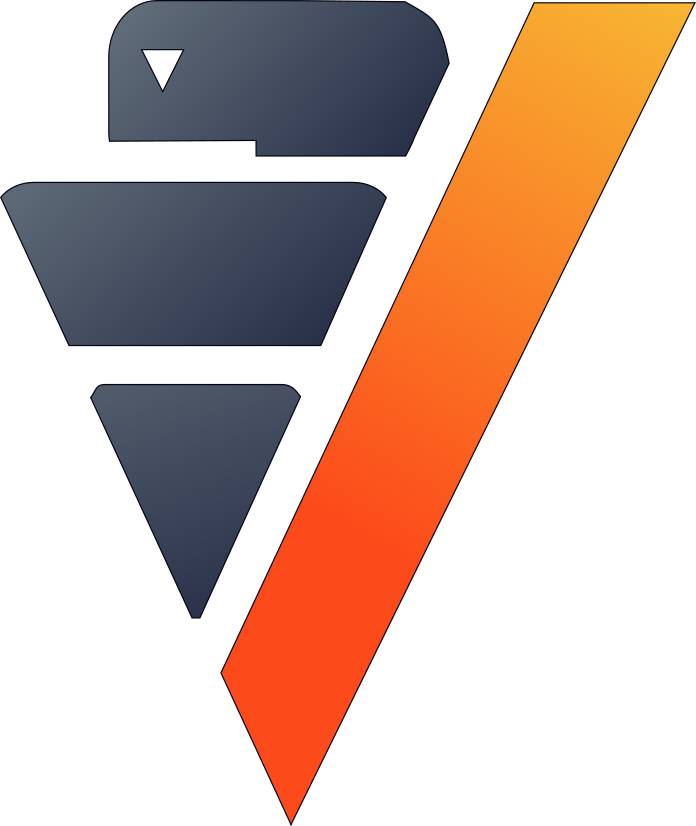

In [7]:
%%sql 
select distinct component, table_name, description 
from data_collector
where component in ('ProjectionsUsed', 'RequestsIssued');

下面我们就来创建两个视图来获取血缘关系图的节点和边信息。

只有两条查询语句，这就是全部了，足够简单了吧！

In [8]:
%%sql
create or replace view datalineage_edges as
select distinct *
from (
select p1.table_oid target
    , p2.table_oid source
    /* , year(r.time)*1000000+month(r.time)*10000+day(r.time)*100+hour(r.time) timestamp */
    /*, r.time timestamp */
    , r.user_name, label, request sql
from dc_projections_used p1 left join dc_projections_used p2 on p1.transaction_id = p2.transaction_id and p1.statement_id = p2.statement_id and p1.node_name = p2.node_name
join dc_requests_issued r on p2.transaction_id = r.transaction_id and p2.statement_id = r.statement_id and p2.node_name = r.node_name
where p1.io_type = 'output' and p2.io_type = 'input'
and (p1.table_schema, p1.table_name) <> (p2.table_schema, p2.table_name)
    and p1.table_schema not in ('v_internal', 'v_catalog', 'v_monitor', 'v_func', 'v_txtindex') 
    /* and filter by r.time, r.user_name, label, request */
    and p1.table_schema in ('mocklanding', 'mockdw')
) t
/* order by timestamp desc */
;

create or replace view datalineage_nodes as
select distinct p1.table_oid id
    , p1.table_schema || '.' || p1.table_name label
    , comment
    , count(*) weight
from dc_projections_used p1 left join dc_projections_used p2 on p1.transaction_id = p2.transaction_id and p1.statement_id = p2.statement_id and p1.node_name = p2.node_name
join dc_requests_issued r on p2.transaction_id = r.transaction_id and p2.statement_id = r.statement_id and p2.node_name = r.node_name
left join vs_comments c on p1.table_oid = c.objectoid
where p2.io_type = 'input'
    and r.request_type in ('LOAD', 'QUERY')
    and p1.table_schema not in ('v_internal', 'v_catalog', 'v_monitor', 'v_func', 'v_txtindex') 
    /* and filter by time, table_schema, user_name */
    and p1.table_schema in ('mocklanding', 'mockdw')
group by p1.table_oid, p1.table_schema, p1.table_name, comment
order by 2
;


CREATE
CREATE


### 2.1 查询血缘信息

我们来具体浏览一下前述样例仓库模型的血缘关系信息数据。

先用列表的方式来看看图的节点信息。

,123idInteger,AbclabelVarchar(257),AbccommentVarchar(8192),123weightInteger
1,45035996273910792,mockdw.dimStore,门店(维度),12
2,45035996273910780,mockdw.dimCustomer,客户(维度),11
3,45035996273910824,mocklanding.city,城市,9
4,45035996273910786,mockdw.dimMovie,影片(维度),9
5,45035996273910830,mocklanding.address,地址,9
6,45035996273910818,mocklanding.country,国家,9
7,45035996273910880,mocklanding.payment,支付,8
8,45035996273910774,mockdw.dimDate,日期(维度),8
9,45035996273910860,mocklanding.rental,租赁,7
10,45035996273910798,mockdw.factSales,销售(事实),7

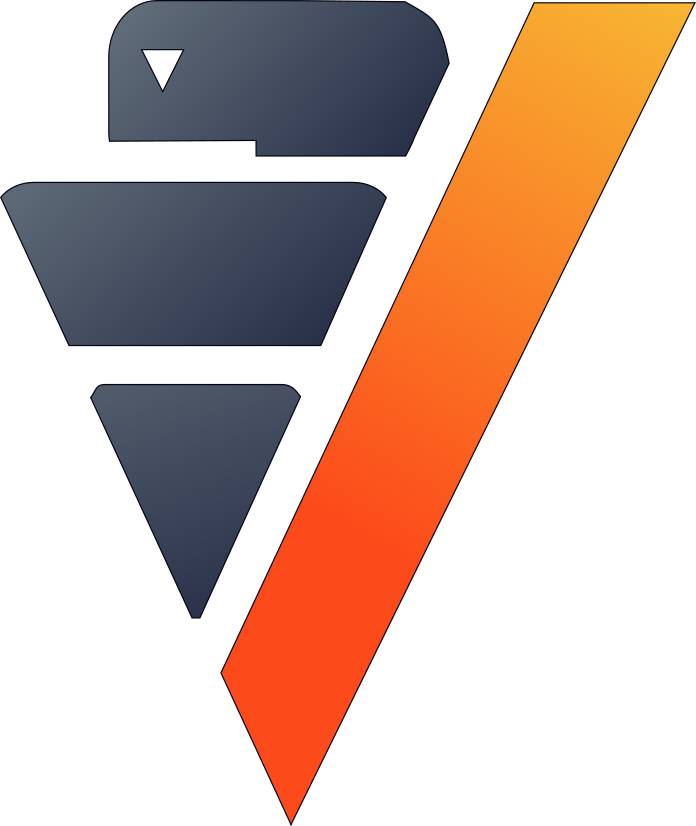

In [9]:
%sql select * from datalineage_nodes order by weight desc;

再看看图的边信息。

,123targetInteger,123sourceInteger,Abcuser_nameVarchar(128),AbcVarchar(128),AbcVarchar(64000)
1,45035996273910798,45035996273910860,dbadmin,,"<input style=""background-color: #FAFAFA; border: none; text-align: center; width: 270px;"" type=""text"" value=""INSERT /*+ LABEL (000_rental_movie_005_populate_factSales) */ INTO mockdw.factSales(date_key, customer_key, movie_key, store_key, sales_amount) SELECT d.date_key, c.customer_key, m.movie_key, s.store_key, p.amount AS sales_amount FROM mocklanding.payment p JOIN mocklanding.rental r ON r.rental_id = p.rental_id JOIN mocklanding.inventory i ON i.inventory_id = r.inventory_id JOIN mockdw.dimDate d ON d.date = p.payment_date JOIN mockdw.dimCustomer c ON c.customer_id = p.customer_id JOIN mockdw.dimMovie m ON m.film_id = i.film_id JOIN mockdw.dimStore s ON s.store_id = i.store_id"" readonly>"
2,45035996273910792,45035996273910848,dbadmin,,"<input style=""background-color: #FAFAFA; border: none; text-align: center; width: 270px;"" type=""text"" value=""INSERT /*+ LABEL (000_rental_movie_004_update_dimStore) */ INTO mockdw.dimStore(store_key, store_id, address, address2, district, city, country, postal_code, manager_first_name, manager_last_name, start_date, end_date) SELECT s.store_id AS store_key, s.store_id, a.address, a.address2, a.district, ci.city, co.country, a.postal_code, st.first_name AS manager_first_name, st.last_name AS manager_last_name, now() AS first_date, now() AS last_date FROM mocklanding.store s JOIN mocklanding.staff st ON st.store_id = s.store_id JOIN mocklanding.address a ON a.address_id = s.address_id JOIN mocklanding.city ci ON ci.city_id = a.city_id JOIN mocklanding.country co ON ci.country_id = co.country_id"" readonly>"
3,45035996273910792,45035996273910824,dbadmin,,"<input style=""background-color: #FAFAFA; border: none; text-align: center; width: 270px;"" type=""text"" value=""INSERT /*+ LABEL (000_rental_movie_004_update_dimStore) */ INTO mockdw.dimStore(store_key, store_id, address, address2, district, city, country, postal_code, manager_first_name, manager_last_name, start_date, end_date) SELECT s.store_id AS store_key, s.store_id, a.address, a.address2, a.district, ci.city, co.country, a.postal_code, st.first_name AS manager_first_name, st.last_name AS manager_last_name, now() AS first_date, now() AS last_date FROM mocklanding.store s JOIN mocklanding.staff st ON st.store_id = s.store_id JOIN mocklanding.address a ON a.address_id = s.address_id JOIN mocklanding.city ci ON ci.city_id = a.city_id JOIN mocklanding.country co ON ci.country_id = co.country_id"" readonly>"
4,45035996273910780,45035996273910870,dbadmin,,"<input style=""background-color: #FAFAFA; border: none; text-align: center; width: 270px;"" type=""text"" value=""INSERT /*+LABEL (000_rental_movie_002_update_dimCustomer) */ INTO mockdw.dimCustomer (customer_key, customer_id, first_name, last_name, email, address, address2, district, city, country, postal_code, phone, active, create_date, start_date, end_date) SELECT c.customer_id AS customer_key, c.customer_id, c.first_name, c.last_name, c.email, a.address, a.address2, a.district, ci.city, co.country, a.postal_code, a.phone, c.active, now() AS create_date, now() AS start_date, now() AS end_date FROM mocklanding.customer c JOIN mocklanding.address a ON (c.address_id = a.address_id) JOIN mocklanding.city ci ON (a.city_id = ci.city_id) JOIN mocklanding.country co ON (ci.country_id = co.country_id)"" readonly>"
5,45035996273910798,45035996273910774,dbadmin,,"<input style=""background-color: #FAFAFA; border: none; text-align: center; width: 270px;"" type=""text"" value=""INSERT /*+ LABEL (000_rental_movie_005_populate_factSales) */ INTO mockdw.factSales(date_key, customer_key, movie_key, store_key, sales_amount) SELECT d.date_key, c.customer_key, m.movie_key, s.store_key, p.amount AS sales_amount FROM mocklanding.payment p JOIN mocklanding.rental r ON r.rental_id = p.rental_id JOIN mocklanding.inventory i ON i.inventory_id = r.inventory_id JO
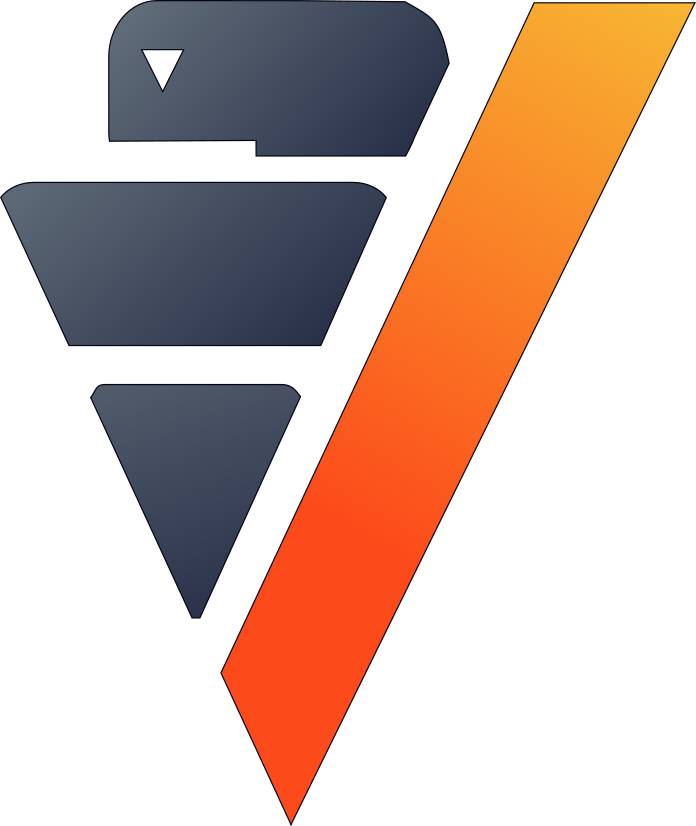

In [10]:
%sql select * from datalineage_edges;

### 2.2 可视化血缘信息

浏览图信息最直观的办法是把它画出来。我们用几行Python代码用graphviz包画出来看看。

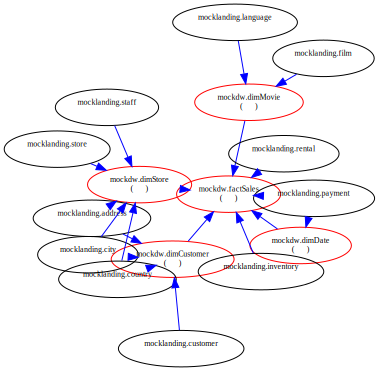

In [11]:
from graphviz import Digraph

graph = Digraph(comment='Data Lineage', engine='neato')

cursor = read_auto_connect().cursor()
query = "select id::varchar, label, comment from datalineage_nodes"
for id, label, comment in cursor.execute(query).fetchall() :
    graph.node(id \
               , label = label+"\n"+comment if comment else label \
               , color= "red" if label.startswith("mockdw.") else 'black' \
               , fontsize="8")

query = "select source::varchar, target::varchar from datalineage_edges"
for source, target in cursor.execute(query).fetchall() :
    graph.edge(source, target, color= "blue")

display(graph.unflatten())

可以清楚的看到数据从mocklanding区的源表流向mockdw的各个维度和事实表。是不是一目了然呢？

## 3. 交互式溯源

利用上一节定义的数据血缘关系视图，我们可以用SQL语句来交互式分析特定关系表在指定深度的数据来源。

请注意您的Vertica数据库的版本号。这里的查询用到了 Vertica 10.1.0+ 才具有的WITH递归查询功能。

,123stepInteger,AbcnameVarchar(255),AbctargetVarchar(255)
1,0,"mockdw.factSales,销售(事实)",[null]
2,1,"mockdw.dimCustomer,客户(维度)","mockdw.factSales,销售(事实)"
3,1,"mockdw.dimDate,日期(维度)","mockdw.factSales,销售(事实)"
4,1,"mockdw.dimMovie,影片(维度)","mockdw.factSales,销售(事实)"
5,1,"mockdw.dimStore,门店(维度)","mockdw.factSales,销售(事实)"
6,1,"mocklanding.inventory,库存","mockdw.factSales,销售(事实)"
7,1,"mocklanding.payment,支付","mockdw.factSales,销售(事实)"
8,1,"mocklanding.rental,租赁","mockdw.factSales,销售(事实)"

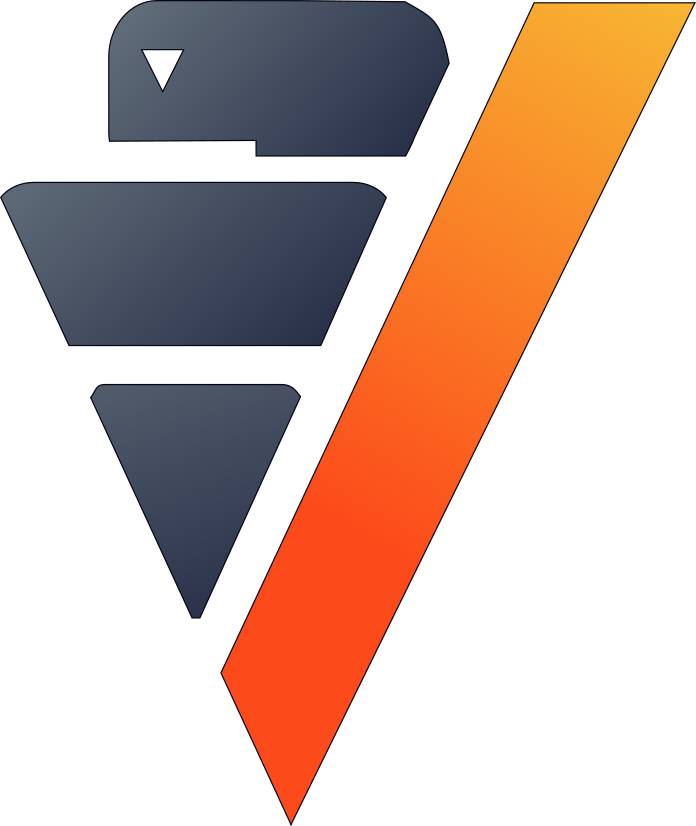

In [12]:
targetName = "mockdw.factSales" # to special table
maxSteps = 1  # from tables within special steps

# This is just a query, using temp table here because WITH statement can not work in sql magic at now 
read_auto_connect().cursor().execute(f"""
create table if not exists tmp_lineage (
    step int,
    name varchar(255),
    target varchar(255)
);

truncate table tmp_lineage;

insert into tmp_lineage
with  /*+ENABLE_WITH_CLAUSE_MATERIALIZATION */ recursive 
tmp_datalineage_nodes as (
    select * from datalineage_nodes
) 
, tmp_datalineage_edges as (
    select * from datalineage_edges
) 
, lineage(id, target, step) as (
    select n.id, null::int as target, 0 as step
    from tmp_datalineage_nodes n
    where n.label = '{targetName}'
    union all
    select s.source as id, t.id as target, t.step+1 as step 
    from tmp_datalineage_edges s
    join lineage t on s.target = t.id
    where t.step < {maxSteps}
)
select step
    , (select label||nvl2(comment, ','||comment, '') 
          from tmp_datalineage_nodes n where n.id = l.id) as name 
    , (select label||nvl2(comment, ','||comment, '') 
          from tmp_datalineage_nodes n where n.id = l.target) as target
from lineage l
order by 1, 2, 3;
""")

%sql select step, name, target from tmp_lineage l order by 1, 2, 3;


## 4. 在Gephi中进行复杂图分析

上面章节只是一个非常简单的样例仓库模型上进行血缘分析数据的图示和交互式操作。如果在一个有成千上万个关系实体和处理SQL语句的实际生产系统中，那样的方法很容易让人昏头转向。我们需要更好的交互式图分析工具来应对复杂的图数据。

Gephi是一个开源、跨平台、可扩展和易用的复杂图数据可视化和分析工具，它可以从CSV和数据库中读数据。

不过Gephi缺省不带Vertica的驱动。Github上有个开源的连Vertica的插件[vertica4gephi](https://github.com/dingqiangliu/vertica4gephi)，按照它的简要说明下载和安装Gephi及最新的vertica4gephi插件就可以。

- 打开Gephi的菜单"File - Import Database - Edge List..."，driver 选择 "Vertica Database"，输入正确的Vertica连接属性和读取数据血缘数据的SQL，导入血缘关系图的节点和边信息。

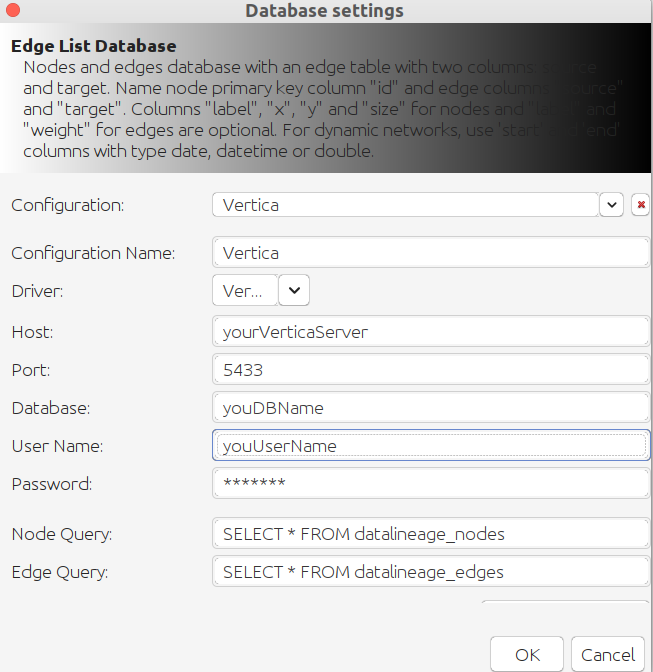

- 在Gephi中可以方便地进行复杂图形的交互式分析操作。

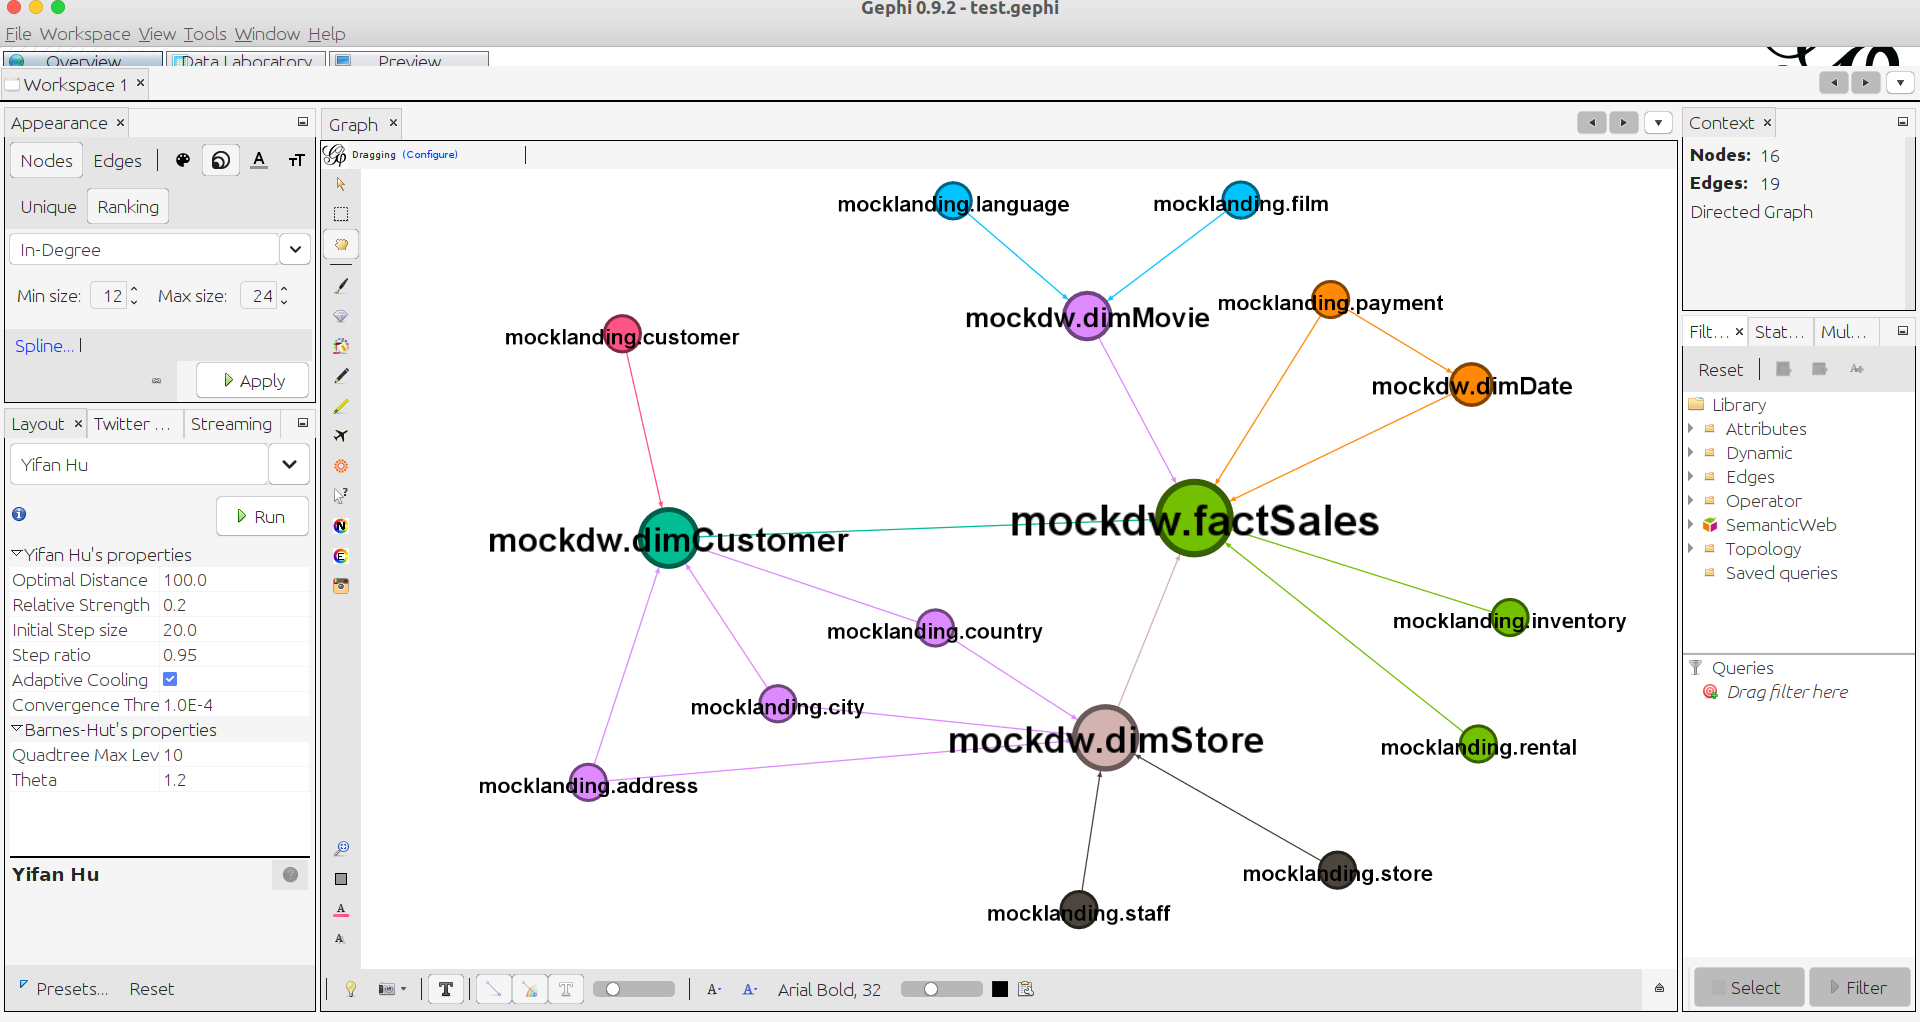

## 5. 后续

到这里我们可以看到，在Vertica中做数据血缘关系分析确实很容易。2个SQL语句就能获得血缘关系图信息，用SQL交互式查询或者用专业的图可视化分析工具，都很简单。

上面的方法虽然很简单，已经能满足大多数场景下的要求。而且您还可以根据实际需要进行扩展，比如血缘关系信息视图上被注释掉的时间序列信息，可以利用起来实时监控仓库的模型更新情况。事实上前文提到的Gephi也可以来分析和推演时序图信息。

另外，Vertica缺省的审计和监控信息只记录到关系表级别。如果您还有兴趣深挖列级别的血缘关系，通过进一步解析SQL的执行计划输出的dot格式图，可以获得列级别的详细计算过程。下面是解析执行计划得到dot图的范例：

In [13]:
dQuery = %sql select e.sql from datalineage_nodes n \
join datalineage_edges e on e.target = n.id \
where n.label = 'mockdw.factSales' \
    and e.sql like 'INSERT %' \
limit 1;

query = dQuery.values["sql"][0]
lines = [ a[0] for a in read_auto_connect().cursor().execute("explain verbose "+query).fetchall()]
glines = lines[lines.index("PLAN: BASE QUERY PLAN (GraphViz Format)")+2:]
glines = glines[:glines.index("}")+1]

import re
gstr = re.sub('BASE QUERY PLAN[^"]*', "", "\n".join(glines))
#from graphviz import Source
#source = Source(gstr, format="png")
#source.view()

用graphviz把这个图画出来，是下面这样：

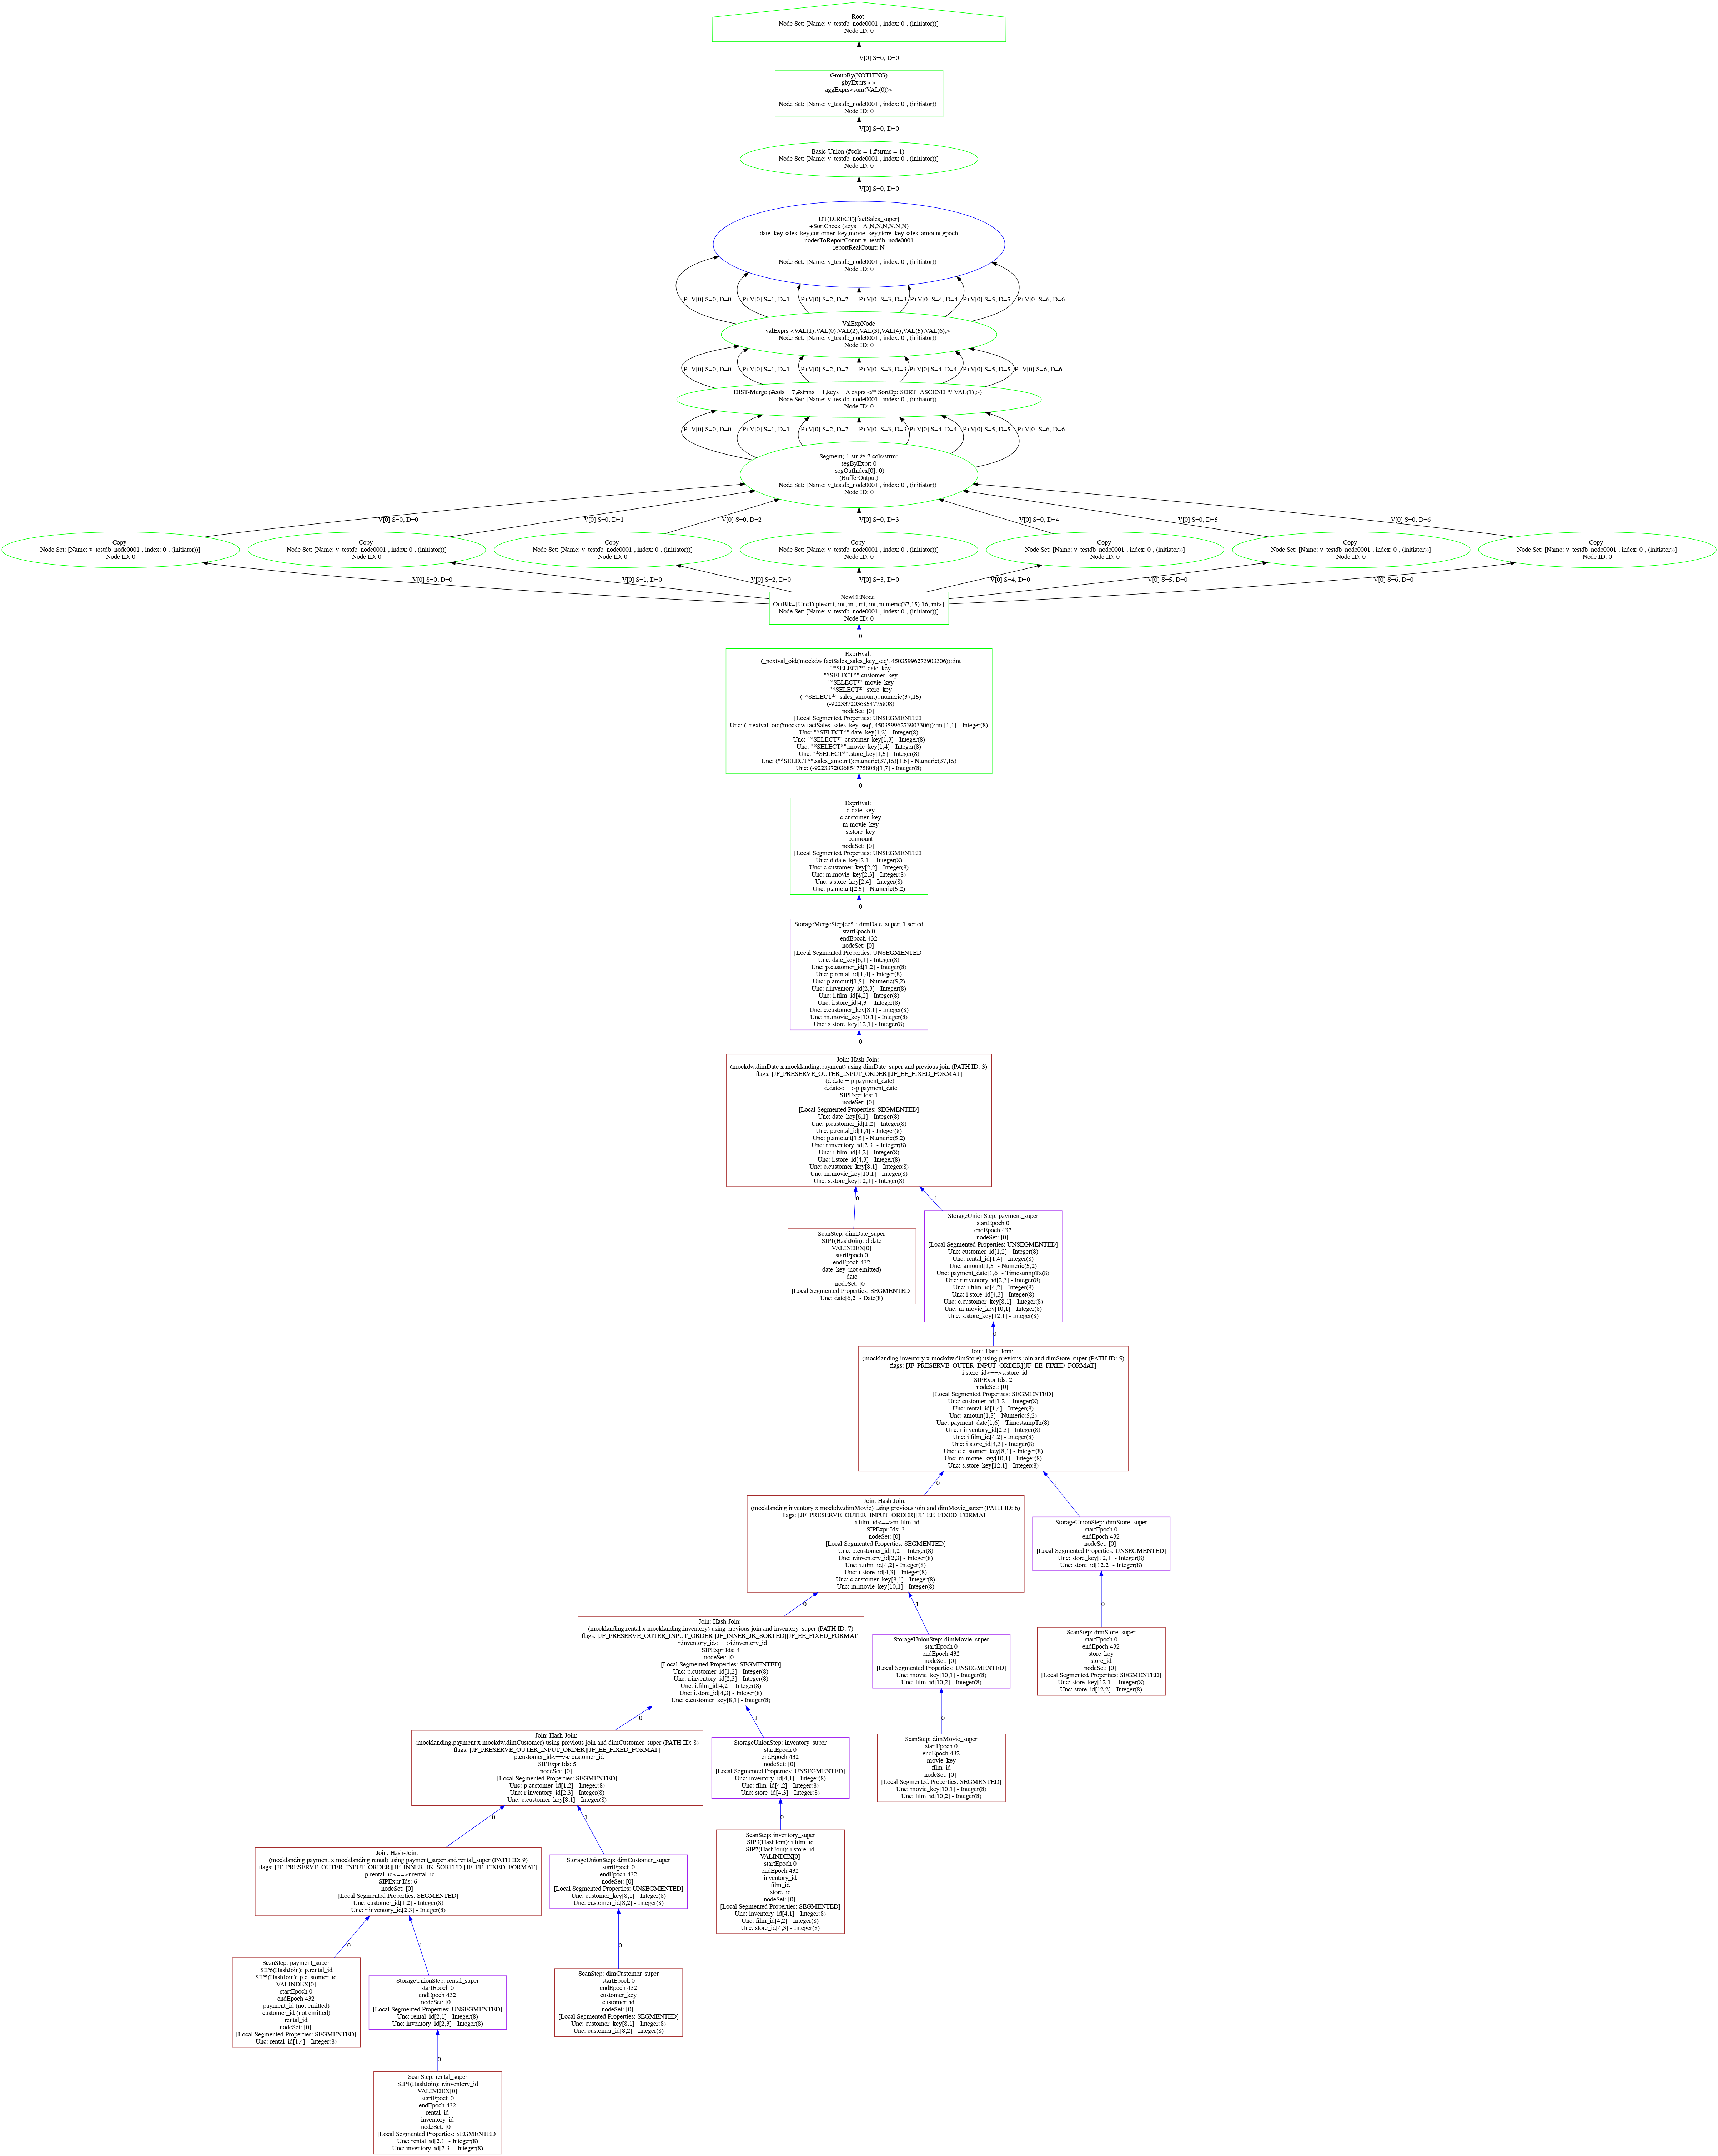

至于具体如何遍历dot格式图获得列级别的详细计算过程，就不在这里赘述了。感兴您可以自己试试。